# TP 2: Poisson process

### 3. Empirical intensities and LOB features

The scientific literature on LOB suggests that intensities of order flows depend on observed LOB features.  
We will discuss this later in the course.  

On your dataset, compute empirical intensities of trades as a function, for example, of the (rescaled) observed queue size or of the observed spread.  
Comment on your findings.

In [93]:
# Step 0 : Download of libraries
## allowed libs :  numpy, scipy, pandas, matplotlib, powerlaw, statsmodels,
## tqdm, Hawkes.

import numpy as np
import scipy
import pandas as pd 
import matplotlib.pyplot as plt
import powerlaw
import statsmodels
from statsmodels import api
import tqdm   
import Hawkes as hwk

In [94]:
# Step 1: Load all files in the directory
data_path = "Data/SG/"
file_list = [
    "SG_20170117.csv.gz",
    "SG_20170118.csv.gz",
    "SG_20170119.csv.gz",
    "SG_20170120.csv.gz",
    "SG_20170123.csv.gz",
    "SG_20170124.csv.gz",
    "SG_20170125.csv.gz",
    "SG_20170126.csv.gz",
    "SG_20170127.csv.gz",
    "SG_20170130.csv.gz",
    "SG_20170131.csv.gz",
    "SG_20170201.csv.gz",
]
# Create a list to store each DataFrame
df_list = []
for file in file_list:
    df = pd.read_csv(data_path + file, compression='gzip')
    df.drop(df.columns[0], axis=1, inplace=True)
    df['ets'] = pd.to_datetime(df['ets'], format="%Y%m%d:%H:%M:%S.%f")
    df_list.append(df)

# Concatenate all DataFrames into one
filename_df = pd.concat(df_list, ignore_index=True)
filename_df['ets'] = pd.to_datetime(filename_df['ets'])
filename_df.head()

,ets,etype,eprice,eqty,eside,bp0,bq0,ap0,aq0
0,2017-01-17 09:01:00.270164,A,45610,1400,B,46010,1066,46085,1445
1,2017-01-17 09:01:00.312121,A,46485,700,S,46010,1066,46085,1445
2,2017-01-17 09:01:00.358162,A,46000,124,B,46010,1066,46085,1445
3,2017-01-17 09:01:00.359972,A,45950,182,B,46010,1066,46085,1445
4,2017-01-17 09:01:00.360001,A,45970,22,B,46010,1066,46085,1445


In [95]:
# Compute the spread: best ask price - best bid price
filename_df['spread'] = filename_df['ap0'] - filename_df['bp0']

# Compute total queue size: sum of best bid and best ask quantities
filename_df['queue_size'] = filename_df['bq0'] + filename_df['aq0']
mean_queue = filename_df['queue_size'].mean()
filename_df['rescaled_queue'] = np.log(1+filename_df['queue_size'] / mean_queue)

In [100]:
def estimate_lambda_event_based(ordinal_df, negative_sample_ratio=1.0, features=['spread', 'rescaled_queue']):

    df = ordinal_df.copy()
    df['ets'] = pd.to_datetime(df['ets'])
    
    trades_df = df[df['etype'] == 'T'].copy()
    non_trades_df = df[df['etype'] != 'T'].copy()
    
    # Create design matrices for the two types
    X_trades = trades_df[features]
    y_trades = np.ones(len(X_trades))
    
    n_neg = int(len(X_trades) * negative_sample_ratio)
    X_neg = non_trades_df[features].sample(n=n_neg, random_state=42)
    y_neg = np.zeros(len(X_neg))
    
    X_full = pd.concat([X_trades, X_neg], ignore_index=True)
    y_full = np.concatenate([y_trades, y_neg])
    
    # Add constant term for intercept
    X_with_const = statsmodels.api.add_constant(X_full)    
    # Fit Poisson
    model = statsmodels.api.GLM(y_full, X_with_const, family=statsmodels.api.families.Poisson()).fit()
    
    # Predict intensity
    X_full['lambda_hat'] = model.predict(X_with_const)
    X_full['y'] = y_full
    
    return X_full, model

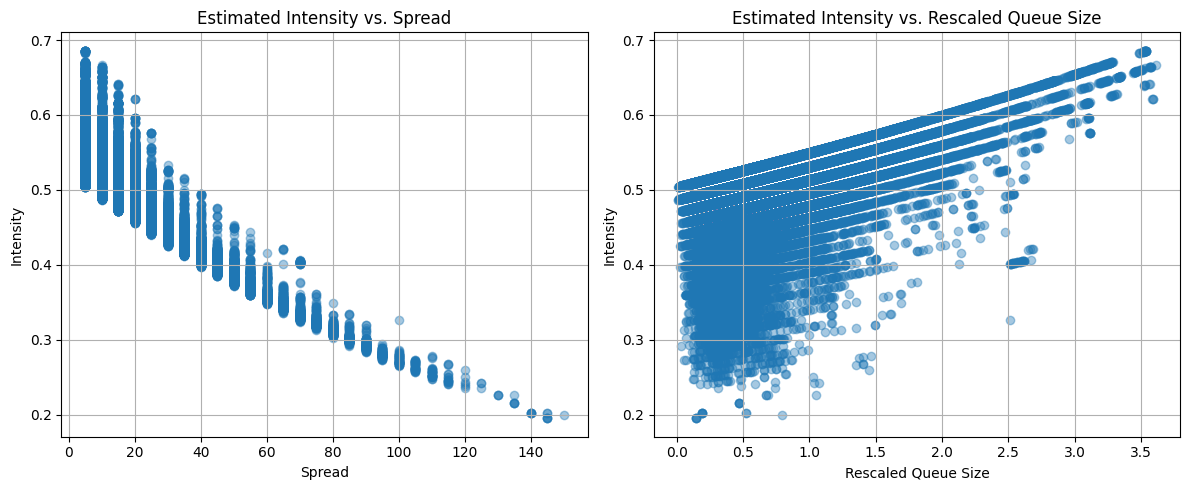

In [102]:
# Estimate the trade intensity based on LOB features
X_lambda, fitted_model = estimate_lambda_event_based(filename_df)

# Plotting the estimated intensity as a function of LOB features
plt.figure(figsize=(12, 5))

# Plot intensity vs. spread
plt.subplot(1, 2, 1)
plt.scatter(X_lambda['spread'], X_lambda['lambda_hat'], alpha=0.4)
plt.xlabel('Spread')
plt.ylabel('Intensity')
plt.title('Estimated Intensity vs. Spread')
plt.grid(True)

# Plot intensity vs. rescaled queue size
plt.subplot(1, 2, 2)
plt.scatter(X_lambda['rescaled_queue'], X_lambda['lambda_hat'], alpha=0.4)
plt.xlabel('Rescaled Queue Size')
plt.ylabel('Intensity')
plt.title('Estimated Intensity vs. Rescaled Queue Size')
plt.grid(True)

plt.tight_layout()
plt.show()

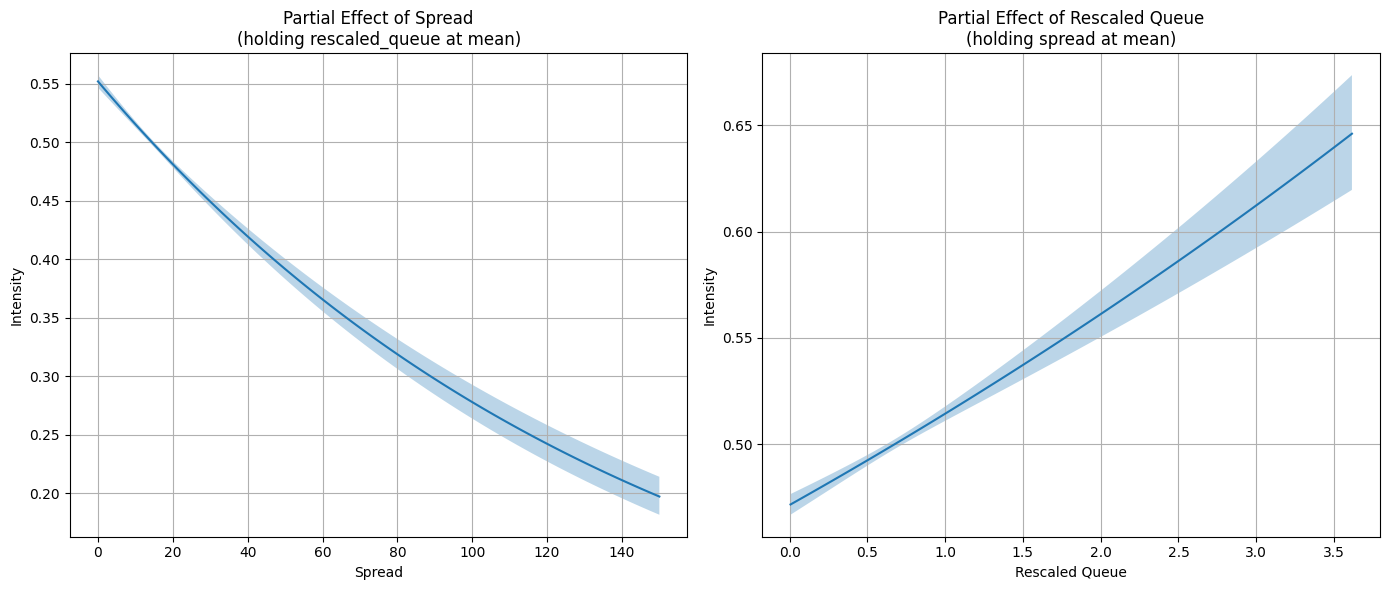

In [101]:
mean_rescaled_queue = X_lambda['rescaled_queue'].mean()
spread_grid = np.linspace(0, 150, 100)
df_plot_spread = pd.DataFrame({'const': 1.0, 'spread': spread_grid, 'rescaled_queue': mean_rescaled_queue})
pred_spread = fitted_model.get_prediction(df_plot_spread).summary_frame(alpha=0.05)
predicted_intensity_spread = pred_spread['mean']
lower_spread = pred_spread['mean_ci_lower']
upper_spread = pred_spread['mean_ci_upper']

mean_spread = X_lambda['spread'].mean()
rescaled_queue_grid = np.linspace(X_lambda['rescaled_queue'].min(), X_lambda['rescaled_queue'].max(), 100)
df_plot_queue = pd.DataFrame({'const': 1.0, 'spread': mean_spread, 'rescaled_queue': rescaled_queue_grid})
pred_queue = fitted_model.get_prediction(df_plot_queue).summary_frame(alpha=0.05)
predicted_intensity_queue = pred_queue['mean']
lower_queue = pred_queue['mean_ci_lower']
upper_queue = pred_queue['mean_ci_upper']

fig, ax = plt.subplots(1, 2, figsize=(14, 6))
ax[0].plot(spread_grid, predicted_intensity_spread)
ax[0].fill_between(spread_grid, lower_spread, upper_spread, alpha=0.3)
ax[0].set_xlabel('Spread')
ax[0].set_ylabel('Intensity')
ax[0].set_title('Partial Effect of Spread\n(holding rescaled_queue at mean)')
ax[0].grid(True)

ax[1].plot(rescaled_queue_grid, predicted_intensity_queue)
ax[1].fill_between(rescaled_queue_grid, lower_queue, upper_queue, alpha=0.3)
ax[1].set_xlabel('Rescaled Queue')
ax[1].set_ylabel('Intensity')
ax[1].set_title('Partial Effect of Rescaled Queue\n(holding spread at mean)')
ax[1].grid(True)

plt.tight_layout()
plt.show()


Using a Poisson regression that labels trades as 1 and non‐trades as 
0, we estimated the trade intensity $\lambda^*(t)=f(spread(t),queue(t))$: 

The results show that bigger 
spreads imply lower intensity, while larger queue 
sizes are associated with a higher intensity. These findings are mostly 
intuitive: a larger spread often reduces trading by raising implicit 
transaction costs, whereas a thicker order book can signal deeper liquidity  
and therefore encourage more frequent trades. 